In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [5]:
#Object Edge Detection in Images
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
K = torch.tensor([[1.0, -1.0]])
K

tensor([[ 1., -1.]])

In [7]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
X.t()

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [9]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [10]:
corr2d(X.t(), K.t())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [11]:
print(X.shape)
print(Y.shape)

torch.Size([6, 8])
torch.Size([6, 7])


In [12]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 5.271
epoch 4, loss 0.913
epoch 6, loss 0.165
epoch 8, loss 0.033
epoch 10, loss 0.007


C:\Users\drhu0\miniconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [13]:
conv2d.weight.data.shape

torch.Size([1, 1, 1, 2])

In [14]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9942, -0.9822]])

In [15]:
conv2d.weight.data

tensor([[[[ 0.9942, -0.9822]]]])

In [16]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
print(X.shape)
print(X)
#Z=conv2d(X)
Z=comp_conv2d(conv2d, X)
print(Z.shape)
print(Z)

torch.Size([8, 8])
tensor([[0.7783, 0.6313, 0.5540, 0.2773, 0.6665, 0.2561, 0.8154, 0.0080],
        [0.7281, 0.4695, 0.7991, 0.3838, 0.6571, 0.9611, 0.5045, 0.0482],
        [0.3548, 0.3208, 0.5490, 0.7453, 0.1037, 0.9661, 0.5677, 0.3737],
        [0.9140, 0.8384, 0.0879, 0.4122, 0.4895, 0.2262, 0.3623, 0.3397],
        [0.6419, 0.4503, 0.8448, 0.1450, 0.7856, 0.3317, 0.0680, 0.0474],
        [0.0273, 0.6322, 0.0836, 0.0439, 0.8883, 0.9328, 0.4172, 0.4890],
        [0.3915, 0.6465, 0.5030, 0.5716, 0.6571, 0.1371, 0.2510, 0.4758],
        [0.8941, 0.2971, 0.3703, 0.3824, 0.9487, 0.6756, 0.0494, 0.7981]])
torch.Size([8, 8])
tensor([[-0.0039,  0.0219, -0.0058,  0.0282, -0.0521,  0.0311, -0.1610,  0.1157],
        [ 0.0826,  0.2507,  0.1287,  0.0863,  0.1455,  0.0318,  0.1396,  0.1023],
        [ 0.0501, -0.0220,  0.1435,  0.1086,  0.1939,  0.1324,  0.3166,  0.0980],
        [ 0.0366,  0.0148,  0.1162,  0.1165, -0.0183,  0.1197,  0.2023,  0.2121],
        [ 0.1139,  0.3850,  0.0193,  0.26

In [17]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [18]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
Z=comp_conv2d(conv2d, X)
Z

tensor([[0.0328, 0.2826, 0.1705, 0.2087],
        [0.2507, 0.4925, 0.5080, 0.6006],
        [0.2068, 0.3142, 0.2131, 0.4919],
        [0.0499, 0.4024, 0.3244, 0.4805]], grad_fn=<ReshapeAliasBackward0>)

In [19]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

In [20]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    # zip函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [21]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
print(X.shape)
print(K.shape)
print(K)
corr2d_multi_in(X, K)

torch.Size([2, 3, 3])
torch.Size([2, 2, 2])
tensor([[[0., 1.],
         [2., 3.]],

        [[1., 2.],
         [3., 4.]]])


tensor([[ 56.,  72.],
        [104., 120.]])

In [22]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [23]:
L = torch.stack((K, K + 1, K + 2), 0)
print(L.shape)
print(L)

torch.Size([3, 2, 2, 2])
tensor([[[[0., 1.],
          [2., 3.]],

         [[1., 2.],
          [3., 4.]]],


        [[[1., 2.],
          [3., 4.]],

         [[2., 3.],
          [4., 5.]]],


        [[[2., 3.],
          [4., 5.]],

         [[3., 4.],
          [5., 6.]]]])


In [24]:
corr2d_multi_in_out(X, L)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [25]:
M = torch.stack((K, K, K), 0)
corr2d_multi_in_out(X, M)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 56.,  72.],
         [104., 120.]],

        [[ 56.,  72.],
         [104., 120.]]])

In [26]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [27]:
X = torch.normal(0, 1, (3, 3, 3))
print(X), print(X.shape)
K = torch.normal(0, 1, (2, 3, 1, 1))
print(K), print(K.shape)
Y1 = corr2d_multi_in_out_1x1(X, K)
print(Y1), print(Y1.shape)
Y2 = corr2d_multi_in_out(X, K)
print(Y2), print(Y2.shape)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

tensor([[[-0.6207,  0.2559,  2.0576],
         [-1.3849,  0.2812,  0.1395],
         [-0.9755,  2.4468, -0.5258]],

        [[ 0.0996,  0.3593,  0.0392],
         [ 0.5603, -0.2253, -1.4088],
         [-0.5290, -0.2237, -0.5053]],

        [[-0.2312,  1.7668,  1.5043],
         [-1.0057,  1.7473, -0.7311],
         [ 1.1415, -0.2571, -1.9017]]])
torch.Size([3, 3, 3])
tensor([[[[ 0.7111]],

         [[-0.0843]],

         [[ 1.0425]]],


        [[[ 0.4461]],

         [[ 0.5400]],

         [[-0.3041]]]])
torch.Size([2, 3, 1, 1])
tensor([[[-0.6908,  1.9935,  3.0280],
         [-2.0804,  2.0405, -0.5443],
         [ 0.5410,  1.4907, -2.3138]],

        [[-0.1527, -0.2292,  0.4815],
         [-0.0093, -0.5277, -0.4762],
         [-1.0679,  1.0488,  0.0710]]])
torch.Size([2, 3, 3])
tensor([[[-0.6908,  1.9935,  3.0280],
         [-2.0804,  2.0405, -0.5443],
         [ 0.5410,  1.4907, -2.3138]],

        [[-0.1527, -0.2292,  0.4815],
         [-0.0093, -0.5277, -0.4762],
         [-1.0679,

In [28]:
#Pooling
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [29]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
print(X.shape)
print(X)
pool2d(X, (2, 2))

torch.Size([3, 3])
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])


tensor([[4., 5.],
        [7., 8.]])

In [30]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [31]:
Y = torch.arange(16, dtype=torch.float32).reshape((4, 4))
pool2d(Y, (2, 2))

tensor([[ 5.,  6.,  7.],
        [ 9., 10., 11.],
        [13., 14., 15.]])

In [32]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
print(X.shape)
X

torch.Size([1, 1, 4, 4])


tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [33]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[10.]]]])

In [34]:
pool2d = nn.MaxPool2d(3, padding=0, stride=1)
pool2d(X)

tensor([[[[10., 11.],
          [14., 15.]]]])

In [35]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [36]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [37]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

In [38]:
#LeNet
import torch
from torch import nn
from d2l import torch as d2l

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), 
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), 
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            # 默认情况下，“Dense”会自动将形状为（批量大小，通道数，高度，宽度）的输入，
            # 转换为形状为（批量大小，通道数*高度*宽度）的输入
            nn.LazyLinear(120), 
            nn.Sigmoid(),
            nn.LazyLinear(84), 
            nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [39]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


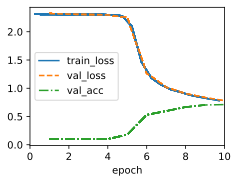

In [40]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [41]:
class LeNet_DrHu(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
			#6->32 
            nn.LazyConv2d(32, kernel_size=5, padding=2), nn.ReLU(),
			#AvgPool2d->MaxPooling2D
            nn.MaxPool2d(kernel_size=2, stride=2),
			#16->64
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
			#AvgPool2d->MaxPooling2D
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

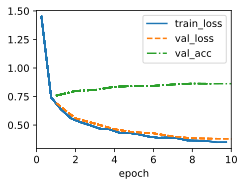

In [42]:
trainer_DrHu = d2l.Trainer(max_epochs=10, num_gpus=1)
data_DrHu = d2l.FashionMNIST(batch_size=32)
model_DrHu = LeNet_DrHu(lr=0.005)
model_DrHu.apply_init([next(iter(data_DrHu.get_dataloader(True)))[0]], init_cnn)
trainer_DrHu.fit(model_DrHu, data_DrHu)

In [43]:
model_DrHu.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 32, 28, 28])
ReLU output shape:	 torch.Size([1, 32, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 32, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])
